In [142]:
import numpy as np
import mne
from mne.datasets import sample
import numpy as np

import mne
mne.set_log_level(verbose='CRITICAL')
from mne.datasets import multimodal
from mne import channels, evoked, create_info
import matplotlib.pyplot as plt

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import scipy.signal as sl
from typing import Optional
import scipy as sp
import sys
from nilearn import plotting
sys.path.insert(1, os.path.realpath(os.path.pardir))
from deepmeg.experimental.models import SPIRIT
from deepmeg.data.datasets import EpochsDataset, read_epochs_dataset
from torch.utils.data import DataLoader
from deepmeg.preprocessing.transforms import zscore
import torch
from collections import defaultdict
import torchmetrics
from deepmeg.training.callbacks import Callback, EarlyStopping, L2Reg, PrintingCallback
from deepmeg.experimental.interpreters import SPIRITInterpreter
import random
import torch.nn as nn
from deepmeg.models.interpretable import BaseModel


def plot_metrics(metrics: dict[str, np.ndarray]):
    plot_dict = defaultdict(dict)

    for metric, values in metrics.items():
        metric_data = metric.split('_')
        metric_name = '_'.join(metric_data[:-1])
        metric_kind = metric_data[-1]
        plot_dict[metric_name][metric_kind] = values

    for metric_name, kind_dict in plot_dict.items():
        legend = list()
        for metric_kind, kind in kind_dict.items():
            plt.plot(kind)
            legend.append(metric_kind)
        plt.title(metric_name)
        plt.legend(legend)
        plt.show()

def accuracy(predictions, targets):

    # Convert one-hot encoded labels to class indices
    targets = torch.argmax(targets, dim=1)

    # Compute predicted class indices
    _, predicted = torch.max(predictions, dim=1)

    # Compute accuracy
    correct = torch.sum(predicted == targets)
    total = targets.shape[0]
    accuracy = correct / total

    return accuracy


In [ ]:
from mne.datasets import multimodal
fname_raw = os.path.join(multimodal.data_path(), 'multimodal_raw.fif')
info = mne.io.read_raw_fif(fname_raw).resample(600).pick_types(meg='grad').info

In [143]:
class LFCNN_original(BaseModel):

    def __init__(
        self,
        n_channels: int,
        n_times: int,
        n_latent: int,
        filter_size: int,
        pool_factor: int,
        n_outputs: int
    ):
        super().__init__()
        self.pool_factor = pool_factor
        self.n_latent = n_latent
        # self.denoising_layer = RecurrentLayer(n_channels, n_channels)
        self.unmixing_layer = nn.Conv1d(n_channels, n_latent, kernel_size=1, bias=True)
        self.temp_conv = nn.Conv1d(n_latent, n_latent, kernel_size=filter_size, bias=True, groups=n_latent, padding='same')
        self.max_pool = nn.MaxPool2d((1, pool_factor))
        self.relu = nn.ReLU()
        final_out_features = (n_times//pool_factor)*n_latent
        self.fc_layer = nn.Linear(final_out_features, n_outputs)


    def forward(self, x: torch.Tensor):
        # x = self.denoising_layer(x)
        x = self.unmixing_layer(x)
        # x = self.denoising_layer(x)
        x = self.temp_conv(x)
        x = self.relu(x)
        # x = torch.stack([lw(x[:, branch_n, :]) for lw, branch_n in zip(self.temp_sel, range(self.n_latent))], -2)
        x = self.max_pool(x)
        # x = self.denoising_layer(x)
        x = torch.flatten(x, 1)
        return self.fc_layer(x)

X = torch.rand((1, 204, 301))

LFCNN_original(204, 301, 8, 50, 10, 8)(X)

tensor([[ 0.1058, -0.0179, -0.1054, -0.1410, -0.0369, -0.0259, -0.0760, -0.0166]],
       grad_fn=<AddmmBackward0>)

In [144]:
dataset = read_epochs_dataset('../data/multimodal.pt')
train, test = torch.utils.data.random_split(dataset, [.7, .3])
x, y = next(iter(DataLoader(test, len(test))))
y.shape

torch.Size([282, 8])

In [145]:
kwargs = dict(
    n_channels=x.shape[1],
    n_times=x.shape[-1],
    filter_size=50,
    n_latent=8,
    pool_factor=10,
    n_outputs=y.shape[-1]
)

In [146]:
LFCNN_original(
    **kwargs
)(x).shape

torch.Size([282, 8])

In [189]:
from deepmeg.models.interpretable import LFCNN, BaseModel
# model = TSNet(**lfcnn_kwargs)

model = LFCNN_original(
    **kwargs
)

optimizer = torch.optim.Adam
loss = torch.nn.BCEWithLogitsLoss()
# metric = torchmetrics.functional.classification.binary_accuracy
metric = accuracy

model.compile(
    optimizer,
    loss,
    metric,
    callbacks=[
        PrintingCallback(), # print ongoing training history
        EarlyStopping(patience=15, monitor='loss_val', restore_best_weights=True), # perform early stopping with restoring best weights
        L2Reg(
            [
                'unmixing_layer.weight',
                'temp_conv.weight',
            ], lambdas=.01
        ) # l2 regularization for weights of spatial- and temporal filtering layers
    ]
)

In [190]:
if hasattr(sys.stdout, 'file'):
    sys.stdout = sys.stdout.file

Epoch 0:  loss_train:  0.7078   |    accuracy_train:  0.1305   |    loss_val:  0.6470   |    accuracy_val:  0.0989
Epoch 1:  loss_train:  0.6167   |    accuracy_train:  0.1305   |    loss_val:  0.5649   |    accuracy_val:  0.0989
Epoch 2:  loss_train:  0.5380   |    accuracy_train:  0.1305   |    loss_val:  0.4950   |    accuracy_val:  0.0989
Epoch 3:  loss_train:  0.4734   |    accuracy_train:  0.1305   |    loss_val:  0.4453   |    accuracy_val:  0.0989
Epoch 4:  loss_train:  0.4312   |    accuracy_train:  0.1305   |    loss_val:  0.4232   |    accuracy_val:  0.1045
Epoch 5:  loss_train:  0.4155   |    accuracy_train:  0.1322   |    loss_val:  0.4232   |    accuracy_val:  0.1045
Epoch 6:  loss_train:  0.4163   |    accuracy_train:  0.1369   |    loss_val:  0.4268   |    accuracy_val:  0.1156
Epoch 7:  loss_train:  0.4162   |    accuracy_train:  0.1436   |    loss_val:  0.4219   |    accuracy_val:  0.1704
Epoch 8:  loss_train:  0.4082   |    accuracy_train:  0.2337   |    loss_val:  0

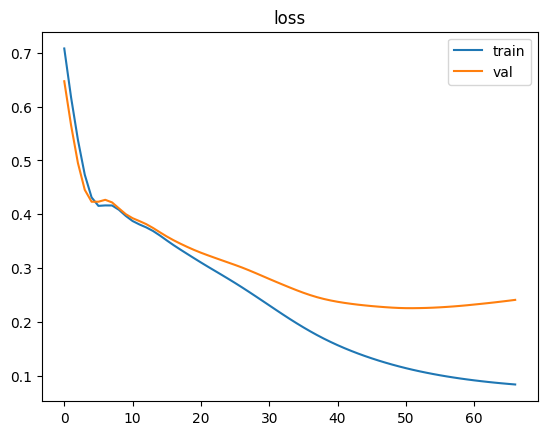

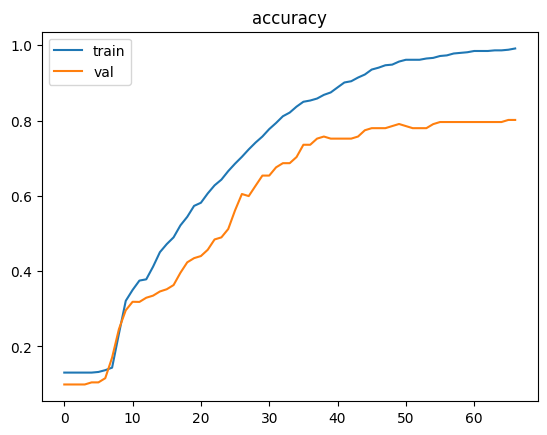

In [191]:
history = model.fit(train, n_epochs=150, batch_size=200, val_batch_size=60)
plot_metrics(history)

In [192]:
train_result = model.evaluate(train)
result = model.evaluate(test)

for measure, value in train_result.items():
    print(f'train_{measure}: {value}')

for measure, value in result.items():
    print(f'{measure}: {value}')

train_loss: 0.13678668778051029
train_accuracy: 0.9202797250314192
loss: 0.2659675804051486
accuracy: 0.6883116960525513


In [155]:
class LFCNN(BaseModel):

    def __init__(
        self,
        n_channels: int,
        n_times: int,
        n_latent: int,
        filter_size: int,
        pool_factor: int,
        n_outputs: int
    ):
        super().__init__()
        self.pool_factor = pool_factor
        self.n_latent = n_latent
        # self.denoising_layer = RecurrentLayer(n_channels, n_channels)
        self.unmixing_layer = nn.Conv1d(n_channels, n_latent, kernel_size=1, bias=True)
        self.temp_conv = nn.Conv1d(n_latent, n_latent, kernel_size=filter_size, bias=True, groups=n_latent, padding='same')
        final_out_features = (n_times//pool_factor)*n_latent if not n_times%pool_factor else (n_times//pool_factor + 1)*n_latent
        self.fc_layer = nn.Linear(final_out_features, n_outputs)


    def forward(self, x: torch.Tensor):
        # x = self.denoising_layer(x)
        x = self.unmixing_layer(x)
        # x = self.denoising_layer(x)
        x = self.temp_conv(x)
        # x = torch.stack([lw(x[:, branch_n, :]) for lw, branch_n in zip(self.temp_sel, range(self.n_latent))], -2)
        x = x[:, :, ::self.pool_factor].contiguous()
        # x = self.denoising_layer(x)
        x = torch.flatten(x, 1)
        return self.fc_layer(x)

X = torch.rand((1, 204, 301))

LFCNN(204, 301, 8, 50, 10, 8)(X)

tensor([[ 0.2497,  0.1366, -0.0383, -0.0079, -0.2224,  0.2243, -0.3495, -0.1375]],
       grad_fn=<AddmmBackward0>)

In [181]:
from deepmeg.models.interpretable import LFCNN

model = LFCNN(
    **kwargs
)

optimizer = torch.optim.Adam
loss = torch.nn.BCEWithLogitsLoss()
# metric = torchmetrics.functional.classification.binary_accuracy
metric = accuracy

model.compile(
    optimizer,
    loss,
    metric,
    callbacks=[
        PrintingCallback(), # print ongoing training history
        EarlyStopping(patience=15, monitor='loss_val', restore_best_weights=True), # perform early stopping with restoring best weights
        L2Reg(
            [
                'unmixing_layer.weight',
                'temp_conv.weight',
            ], lambdas=.01
        ) # l2 regularization for weights of spatial- and temporal filtering layers
    ]
)

Epoch 0:  loss_train:  0.7144   |    accuracy_train:  0.1186   |    loss_val:  0.7043   |    accuracy_val:  0.0878
Epoch 1:  loss_train:  0.6872   |    accuracy_train:  0.1467   |    loss_val:  0.6792   |    accuracy_val:  0.1204
Epoch 2:  loss_train:  0.6590   |    accuracy_train:  0.1821   |    loss_val:  0.6520   |    accuracy_val:  0.1371
Epoch 3:  loss_train:  0.6279   |    accuracy_train:  0.2117   |    loss_val:  0.6224   |    accuracy_val:  0.1427
Epoch 4:  loss_train:  0.5931   |    accuracy_train:  0.2279   |    loss_val:  0.5905   |    accuracy_val:  0.1534
Epoch 5:  loss_train:  0.5553   |    accuracy_train:  0.2668   |    loss_val:  0.5572   |    accuracy_val:  0.1701
Epoch 6:  loss_train:  0.5164   |    accuracy_train:  0.2770   |    loss_val:  0.5237   |    accuracy_val:  0.1645
Epoch 7:  loss_train:  0.4795   |    accuracy_train:  0.2999   |    loss_val:  0.4926   |    accuracy_val:  0.1805
Epoch 8:  loss_train:  0.4481   |    accuracy_train:  0.3434   |    loss_val:  0

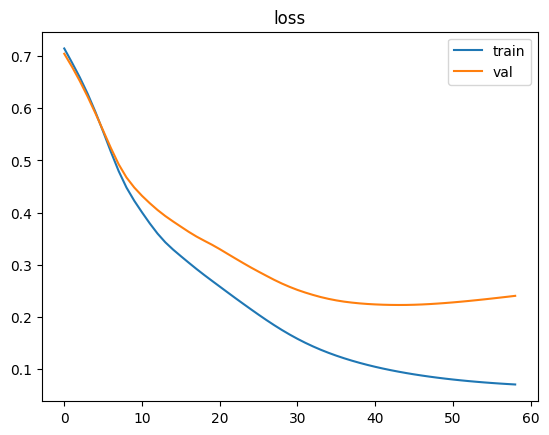

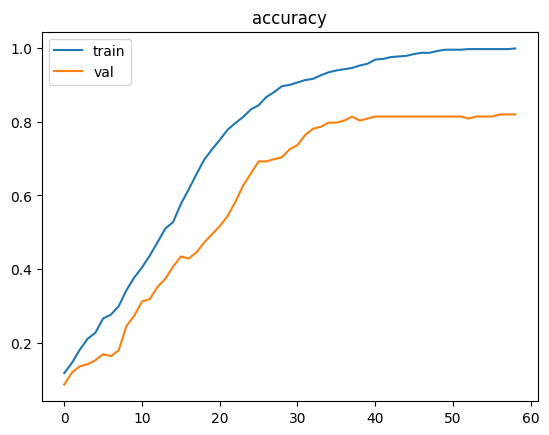

In [182]:
history = model.fit(train, n_epochs=150, batch_size=200, val_batch_size=60)
plot_metrics(history)

In [183]:
train_result = model.evaluate(train)
result = model.evaluate(test)

for measure, value in train_result.items():
    print(f'train_{measure}: {value}')

for measure, value in result.items():
    print(f'{measure}: {value}')

train_loss: 0.12430970573967154
train_accuracy: 0.9354895136573098
loss: 0.2112118290229277
accuracy: 0.8474025997248563


In [184]:
from deepmeg.experimental.layers import LW
class LFCNNW(BaseModel):

    def __init__(
        self,
        n_channels: int,
        n_times: int,
        n_latent: int,
        filter_size: int,
        pool_factor: int,
        n_outputs: int
    ):
        super().__init__()
        self.pool_factor = pool_factor
        self.n_latent = n_latent
        self.unmixing_layer = nn.Conv1d(n_channels, n_latent, kernel_size=1, bias=True)
        self.temp_conv = nn.Conv1d(n_latent, n_latent, kernel_size=filter_size, bias=True, groups=n_latent, padding='same')
        n_times_resampled = (n_times//pool_factor) if not n_times%pool_factor else (n_times//pool_factor + 1)
        self.temp_sel = nn.ModuleList([LW(n_times_resampled) for _ in range(self.n_latent)])
        final_out_features = n_times_resampled*n_latent
        self.fc_layer = nn.Linear(final_out_features, n_outputs)


    def forward(self, x: torch.Tensor):
        x = self.unmixing_layer(x)
        x = self.temp_conv(x)
        x = x[:, :, ::self.pool_factor].contiguous()
        x = torch.stack([lw(x[:, branch_n, :]) for lw, branch_n in zip(self.temp_sel, range(self.n_latent))], -2)
        x = torch.flatten(x, 1)
        return self.fc_layer(x)

In [185]:
model = LFCNNW(
    **kwargs
)

optimizer = torch.optim.Adam
loss = torch.nn.BCEWithLogitsLoss()
# metric = torchmetrics.functional.classification.binary_accuracy
metric = accuracy

model.compile(
    optimizer,
    loss,
    metric,
    callbacks=[
        PrintingCallback(), # print ongoing training history
        EarlyStopping(patience=15, monitor='loss_val', restore_best_weights=True), # perform early stopping with restoring best weights
        L2Reg(
            [
                'unmixing_layer.weight',
                'temp_conv.weight',
            ], lambdas=.01
        ) # l2 regularization for weights of spatial- and temporal filtering layers
    ]
)

In [186]:
if hasattr(sys.stdout, 'file'):
    sys.stdout = sys.stdout.file

Epoch 0:  loss_train:  0.7273   |    accuracy_train:  0.1305   |    loss_val:  0.7255   |    accuracy_val:  0.1482
Epoch 1:  loss_train:  0.7239   |    accuracy_train:  0.1305   |    loss_val:  0.7220   |    accuracy_val:  0.1482
Epoch 2:  loss_train:  0.7204   |    accuracy_train:  0.1305   |    loss_val:  0.7182   |    accuracy_val:  0.1482
Epoch 3:  loss_train:  0.7164   |    accuracy_train:  0.1305   |    loss_val:  0.7138   |    accuracy_val:  0.1482
Epoch 4:  loss_train:  0.7117   |    accuracy_train:  0.1305   |    loss_val:  0.7084   |    accuracy_val:  0.1482
Epoch 5:  loss_train:  0.7059   |    accuracy_train:  0.1305   |    loss_val:  0.7018   |    accuracy_val:  0.1482
Epoch 6:  loss_train:  0.6988   |    accuracy_train:  0.1305   |    loss_val:  0.6938   |    accuracy_val:  0.1482
Epoch 7:  loss_train:  0.6902   |    accuracy_train:  0.1305   |    loss_val:  0.6840   |    accuracy_val:  0.1430
Epoch 8:  loss_train:  0.6796   |    accuracy_train:  0.1322   |    loss_val:  0

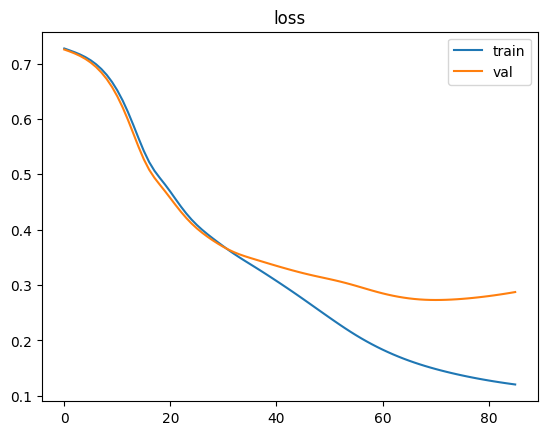

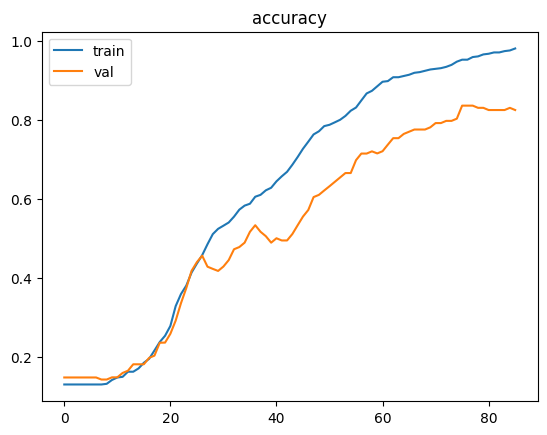

In [187]:
history = model.fit(train, n_epochs=150, batch_size=200, val_batch_size=60)
plot_metrics(history)

In [188]:
train_result = model.evaluate(train)
result = model.evaluate(test)

for measure, value in train_result.items():
    print(f'train_{measure}: {value}')

for measure, value in result.items():
    print(f'{measure}: {value}')

train_loss: 0.1747539693659002
train_accuracy: 0.8993007053028453
loss: 0.24981908093799243
accuracy: 0.7564935088157654


In [209]:
from deepmeg.models import BaseModel
import torch.nn as nn


class RecurrentLayer(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(RecurrentLayer, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim

        self.U = nn.Linear(hidden_dim, hidden_dim)
        self.W = nn.Linear(input_dim, hidden_dim)

    def forward(self, x):
        x = torch.permute(x, (0, 2, 1))
        batch_size = x.size(0)
        seq_len = x.size(1)

        hiddens = list()
        # Initialize the hidden state
        hidden = torch.zeros(batch_size, self.hidden_dim).to(x.device)

        # Iterate over the sequence length
        for t in range(seq_len):
            if t == 0:
                dx = x[:, t, :]
            else:
                dx = x[:, t, :] - x[:, t - 1, :]

            # Apply the recurrence formula
            hidden = self.U(hidden) + self.W(dx)
            # hidden += self.W(dx)
            hiddens.append(hidden)

        return torch.stack(hiddens, dim=1).permute(0, 2, 1)



class LFCNNr(BaseModel):

    def __init__(
        self,
        n_channels: int,
        n_times: int,
        n_latent: int,
        filter_size: int,
        pool_factor: int,
        n_outputs: int
    ):
        super().__init__()
        self.pool_factor = pool_factor
        self.n_latent = n_latent
        self.denoising_layer = RecurrentLayer(n_channels, n_channels)
        # self.denoising_layer = RecurrentLayer(n_channels, n_latent)
        self.unmixing_layer = nn.Conv1d(n_channels, n_latent, kernel_size=1, bias=True)
        # self.denoising_layer = RecurrentLayer(n_latent, n_latent)
        self.temp_conv = nn.Conv1d(n_latent, n_latent, kernel_size=filter_size, bias=True, groups=n_latent, padding='same')
        # self.temp_sel = nn.ModuleList([LW(n_times) for _ in range(self.n_latent)])
        final_out_features = (n_times//pool_factor)*n_latent if not n_times%pool_factor else (n_times//pool_factor + 1)*n_latent
        self.fc_layer = nn.Linear(final_out_features, n_outputs)


    def forward(self, x: torch.Tensor):
        x = self.denoising_layer(x)
        x = self.unmixing_layer(x)
        # x = self.denoising_layer(x)
        x = self.temp_conv(x)
        # x = torch.stack([lw(x[:, branch_n, :]) for lw, branch_n in zip(self.temp_sel, range(self.n_latent))], -2)
        x = x[:, :, ::self.pool_factor].contiguous()
        # x = self.denoising_layer(x)
        x = torch.flatten(x, 1)
        return self.fc_layer(x)

X = torch.rand((1, 64, 600))

LFCNNr(64, 600, 8, 50, 10, 8)(X)

tensor([[-0.0839,  0.0605, -0.1027, -0.0572, -0.0197,  0.0579, -0.0471, -0.0682]],
       grad_fn=<AddmmBackward0>)

In [210]:
LFCNNr(
    **kwargs
)(x).shape

torch.Size([282, 8])

In [214]:
from deepmeg.models.interpretable import LFCNN
# model = TSNet(**lfcnn_kwargs)

model = LFCNNr(
    **kwargs
)

optimizer = torch.optim.Adam
loss = torch.nn.BCEWithLogitsLoss()
# metric = torchmetrics.functional.classification.binary_accuracy
metric = accuracy

model.compile(
    optimizer,
    loss,
    metric,
    callbacks=[
        PrintingCallback(), # print ongoing training history
        EarlyStopping(patience=25, monitor='loss_val', restore_best_weights=True), # perform early stopping with restoring best weights
        L2Reg(
            [
                'unmixing_layer.weight',
                'temp_conv.weight',
            ], lambdas=.01
        ) # l2 regularization for weights of spatial- and temporal filtering layers
    ]
)

In [215]:
if hasattr(sys.stdout, 'file'):
    sys.stdout = sys.stdout.file

Epoch 0:  loss_train:  0.7060   |    accuracy_train:  0.1124   |    loss_val:  0.6732   |    accuracy_val:  0.1482
Epoch 1:  loss_train:  0.6264   |    accuracy_train:  0.1813   |    loss_val:  0.4929   |    accuracy_val:  0.1590
Epoch 2:  loss_train:  1.5455   |    accuracy_train:  0.1374   |    loss_val:  0.5080   |    accuracy_val:  0.1527
Epoch 3:  loss_train:  0.5256   |    accuracy_train:  0.1902   |    loss_val:  0.5911   |    accuracy_val:  0.1586
Epoch 4:  loss_train:  0.5746   |    accuracy_train:  0.2582   |    loss_val:  0.6128   |    accuracy_val:  0.1423
Epoch 5:  loss_train:  0.5835   |    accuracy_train:  0.3227   |    loss_val:  0.6175   |    accuracy_val:  0.1642
Epoch 6:  loss_train:  0.5795   |    accuracy_train:  0.3808   |    loss_val:  0.6147   |    accuracy_val:  0.1478
Epoch 7:  loss_train:  0.5691   |    accuracy_train:  0.4178   |    loss_val:  0.6074   |    accuracy_val:  0.1263
Epoch 8:  loss_train:  0.5545   |    accuracy_train:  0.4563   |    loss_val:  0

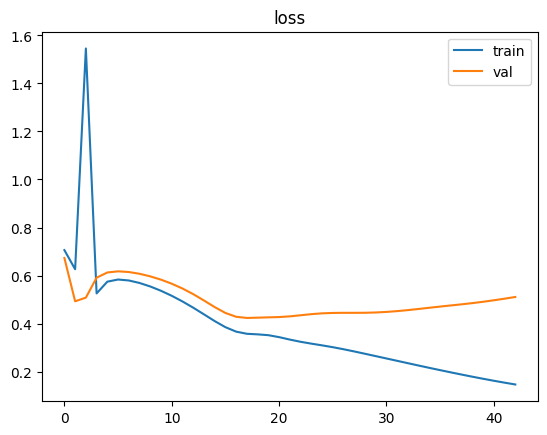

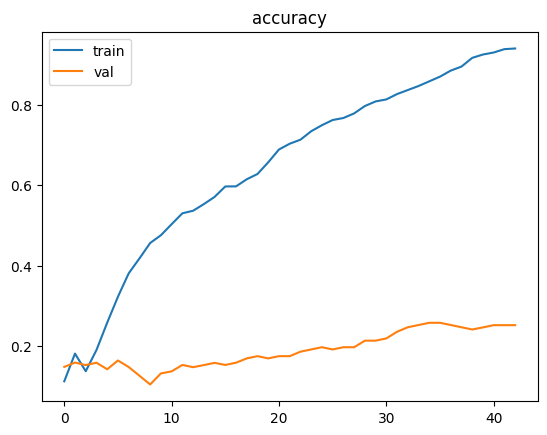

In [216]:
history = model.fit(train, n_epochs=150, batch_size=200, val_batch_size=60)
plot_metrics(history)

In [217]:
train_result = model.evaluate(train)
result = model.evaluate(test)

for measure, value in train_result.items():
    print(f'train_{measure}: {value}')

for measure, value in result.items():
    print(f'{measure}: {value}')

train_loss: 0.3725826957009055
train_accuracy: 0.48741260170936584
loss: 0.4171212776140733
accuracy: 0.2045454586094076


In [46]:
x, y = next(iter(DataLoader(test, len(test))))

In [49]:
x_dmx = model.unmixing_layer(x)
# x = model.denoising_layer(x)
x_flt = model.temp_conv(x_dmx)
# x = torch.stack([lw(x[:, branch_n, :]) for lw, branch_n in zip(model.temp_sel, range(model.n_latent))], -2)
x_ds = x_flt[:, :, ::model.pool_factor].contiguous()
x_dn = model.denoising_layer(x_ds)
x_f = torch.flatten(x_dn, 1)
y_p = model.fc_layer(x_f)
accuracy(y_p, y), torchmetrics.functional.classification.binary_accuracy(y_p, y)

(tensor(0.6879), tensor(0.9131))

In [50]:
y_p

tensor([[-3.6861, -6.9414, -2.3449,  ..., -5.9904, -4.9934, -4.8449],
        [ 0.6605, -2.5775, -5.3357,  ..., -6.0734, -6.9272, -3.8901],
        [-7.6548, -8.5036, -7.9596,  ..., -6.6894,  0.9063,  0.3072],
        ...,
        [-0.1060, -4.7676, -6.0066,  ...,  2.9411, -5.8177, -4.3395],
        [-3.4511, -5.6489, -1.3206,  ..., -4.1637, -4.7399, -7.1611],
        [-6.1494, -3.9667,  0.4051,  ..., -3.1719, -5.7035, -6.6807]],
       grad_fn=<AddmmBackward0>)

In [50]:
x.shape

torch.Size([282, 204, 301])

In [218]:
from deepmeg.models import BaseModel
import torch.nn as nn

class SelfAttention(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.input_dim = input_dim
        self.query = nn.Linear(input_dim, input_dim)
        self.key = nn.Linear(input_dim, input_dim)
        self.value = nn.Linear(input_dim, input_dim)
        self.softmax = nn.Softmax(dim=2)

    def get_qkv(self, x):
        return self.query(x), self.key(x), self.value(x)

    def get_scores(self, queries, keys):
        return torch.bmm(queries, keys.transpose(1, 2)) / (self.input_dim ** 0.5)

    def forward(self, x): # x.shape = (batch_size, n_channels, n_times)
        x = torch.permute(x, (0, 2, 1)) # x.shape = (batch_size, n_times, n_channels)
        queries, keys, values = self.get_qkv(x)
        scores = self.get_scores(queries, keys)
        attention = self.softmax(scores)
        weighted = torch.bmm(attention, values)
        weighted = torch.permute(weighted, (0, 2, 1)) # x.shape = (batch_size, n_channels, n_times)
        return weighted


x = torch.rand((1, 64, 600))

a = SelfAttention(64)

In [61]:
a(x).shape

torch.Size([1, 64, 600])

In [57]:
q, k, v = a.get_qkv(torch.permute(x, (0, 2, 1)))
q.shape, k.shape, v.shape

(torch.Size([1, 600, 64]), torch.Size([1, 600, 64]), torch.Size([1, 600, 64]))

In [59]:
a.get_scores(q, k).shape

torch.Size([1, 600, 600])

In [255]:
class LFCNNattn(BaseModel):

    def __init__(
        self,
        n_channels: int,
        n_times: int,
        n_latent: int,
        filter_size: int,
        pool_factor: int,
        n_outputs: int
    ):
        super().__init__()
        self.pool_factor = pool_factor
        self.n_latent = n_latent
        self.unmixing_layer = nn.Conv1d(n_channels, n_latent, kernel_size=1, bias=True)
        self.temp_conv = nn.Conv1d(n_latent, n_latent, kernel_size=filter_size, bias=True, groups=n_latent, padding='same')
        self.temp_sel = SelfAttention(n_latent)
        final_out_features = (n_times//pool_factor)*n_latent if not n_times%pool_factor else (n_times//pool_factor + 1)*n_latent
        self.fc_layer = nn.Linear(final_out_features, n_outputs)


    def forward(self, x: torch.Tensor):
        x = self.unmixing_layer(x)
        x = self.temp_conv(x)
        x = x[:, :, ::self.pool_factor].contiguous()
        x = self.temp_sel(x)
        x = torch.flatten(x, 1)
        return self.fc_layer(x)

X = torch.rand((1, 64, 600))

LFCNNattn(64, 600, 8, 50, 10, 8)(X)

tensor([[-0.0708, -0.1790, -0.1494,  0.0975,  0.0537, -0.0248,  0.0635,  0.0214]],
       grad_fn=<AddmmBackward0>)

In [256]:
from deepmeg.models.interpretable import LFCNN
# model = TSNet(**lfcnn_kwargs)

model = LFCNNattn(
    **kwargs
)

optimizer = torch.optim.Adam
loss = torch.nn.BCEWithLogitsLoss()
# metric = torchmetrics.functional.classification.binary_accuracy
metric = accuracy

model.compile(
    optimizer,
    loss,
    metric,
    callbacks=[
        PrintingCallback(), # print ongoing training history
        EarlyStopping(patience=15, monitor='loss_val', restore_best_weights=True), # perform early stopping with restoring best weights
        L2Reg(
            [
                # 'unmixing_layer.weight',
                'temp_conv.weight',
            ], lambdas=.01
        ) # l2 regularization for weights of spatial- and temporal filtering layers
    ]
)

In [257]:
if hasattr(sys.stdout, 'file'):
    sys.stdout = sys.stdout.file

Epoch 0:  loss_train:  0.6958   |    accuracy_train:  0.1222   |    loss_val:  0.6551   |    accuracy_val:  0.1427
Epoch 1:  loss_train:  0.6392   |    accuracy_train:  0.1238   |    loss_val:  0.6009   |    accuracy_val:  0.1590
Epoch 2:  loss_train:  0.5859   |    accuracy_train:  0.1336   |    loss_val:  0.5504   |    accuracy_val:  0.1645
Epoch 3:  loss_train:  0.5360   |    accuracy_train:  0.1338   |    loss_val:  0.5049   |    accuracy_val:  0.1645
Epoch 4:  loss_train:  0.4912   |    accuracy_train:  0.1322   |    loss_val:  0.4667   |    accuracy_val:  0.1590
Epoch 5:  loss_train:  0.4547   |    accuracy_train:  0.1336   |    loss_val:  0.4391   |    accuracy_val:  0.1753
Epoch 6:  loss_train:  0.4301   |    accuracy_train:  0.1355   |    loss_val:  0.4237   |    accuracy_val:  0.1860
Epoch 7:  loss_train:  0.4173   |    accuracy_train:  0.1355   |    loss_val:  0.4162   |    accuracy_val:  0.1753
Epoch 8:  loss_train:  0.4103   |    accuracy_train:  0.1324   |    loss_val:  0

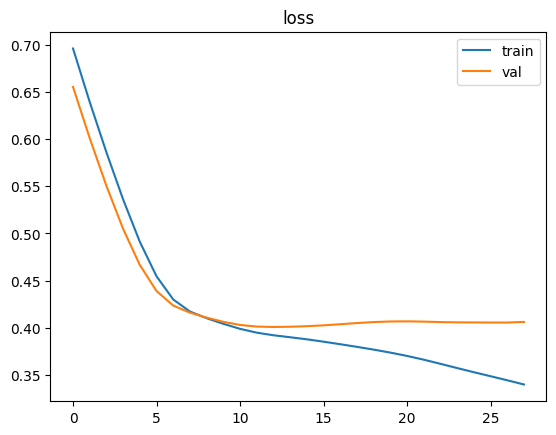

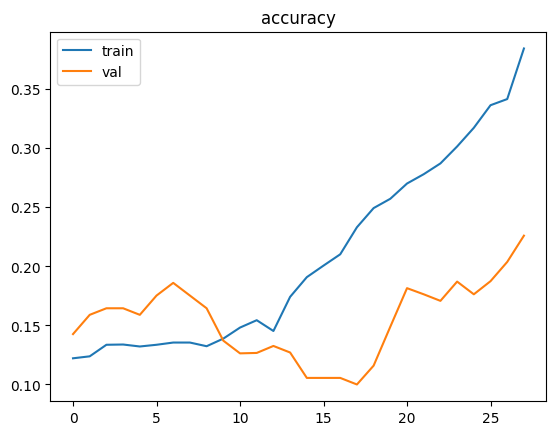

In [258]:
history = model.fit(train, n_epochs=150, batch_size=200, val_batch_size=60)
plot_metrics(history)

In [259]:
train_result = model.evaluate(train)
result = model.evaluate(test)

for measure, value in train_result.items():
    print(f'train_{measure}: {value}')

for measure, value in result.items():
    print(f'{measure}: {value}')

train_loss: 0.39395195787603204
train_accuracy: 0.15402098338712344
loss: 0.39613093029369006
accuracy: 0.15909091213887389


In [260]:
x, _ = next(iter(DataLoader(test, len(test))))
x = model.unmixing_layer(x)
x = model.temp_conv(x)
x = x[:, :, ::model.pool_factor].contiguous()

In [261]:
q, k, v = model.temp_sel.get_qkv(torch.permute(x, (0, 2, 1)))
q.shape, k.shape, v.shape

(torch.Size([282, 31, 8]), torch.Size([282, 31, 8]), torch.Size([282, 31, 8]))

In [262]:
scores = model.temp_sel.get_scores(q, k).detach().numpy()

In [263]:
scores.shape

(282, 31, 31)

In [264]:
scores.shape

(282, 31, 31)

In [265]:
y[5]

tensor([0., 0., 0., 0., 0., 0., 0., 1.])

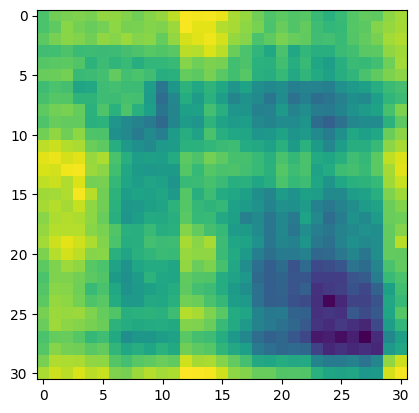

In [267]:
plt.imshow(scores.mean(0))

In [100]:
X.shape

torch.Size([1, 64, 600])

In [61]:
class MultiHeadAttention(nn.Module):
    def __init__(self, input_dim, n_heads=8, dropout=None):
        super().__init__()
        self.input_dim = input_dim
        self.query = nn.Linear(input_dim, input_dim)
        self.key = nn.Linear(input_dim, input_dim)
        self.value = nn.Linear(input_dim, input_dim)
        self.mh = nn.MultiheadAttention(input_dim, n_heads, dropout)

    def get_qkv(self, x):
        return self.query(x), self.key(x), self.value(x)

    def get_scores(self, queries, keys):
        return torch.bmm(queries, keys.transpose(1, 2)) / (self.input_dim ** 0.5)

    def forward(self, x): # x.shape = (batch_size, n_channels, n_times)
        x = torch.permute(x, (0, 2, 1)) # x.shape = (batch_size, n_times, n_channels)
        queries, keys, values = self.get_qkv(x)
        attn_output = self.mh(queries, keys, values, need_weights=False)[0]
        return attn_output

In [62]:
mh = MultiHeadAttention(64, 8, .4)

In [63]:
o = mh(X)
o.shape

torch.Size([1, 600, 64])

In [64]:
class LFCNNmh(BaseModel):

    def __init__(
        self,
        n_channels: int,
        n_times: int,
        n_latent: int,
        filter_size: int,
        pool_factor: int,
        n_outputs: int,
        n_heads = 8
    ):
        super().__init__()
        self.pool_factor = pool_factor
        self.n_latent = n_latent
        self.unmixing_layer = nn.Conv1d(n_channels, n_latent, kernel_size=1, bias=True)
        self.temp_conv = nn.Conv1d(n_latent, n_latent, kernel_size=filter_size, bias=True, groups=n_latent, padding='same')
        self.temp_sel = MultiHeadAttention(n_latent, n_heads, .4)
        final_out_features = (n_times//pool_factor)*n_latent if not n_times%pool_factor else (n_times//pool_factor + 1)*n_latent
        self.fc_layer = nn.Linear(final_out_features, n_outputs)


    def forward(self, x: torch.Tensor):
        x = self.unmixing_layer(x)
        x = self.temp_conv(x)
        x = x[:, :, ::self.pool_factor].contiguous()
        x = self.temp_sel(x)
        x = torch.flatten(x, 1)
        return self.fc_layer(x)

X = torch.rand((1, 64, 600))

LFCNNmh(64, 600, 8, 50, 10, 8)(X)

tensor([[ 0.0434, -0.0116,  0.0411, -0.0511,  0.0186,  0.0198, -0.0393, -0.0009]],
       grad_fn=<AddmmBackward0>)

In [130]:
model.state_dict().keys()

odict_keys(['unmixing_layer.weight', 'unmixing_layer.bias', 'temp_conv.weight', 'temp_conv.bias', 'temp_sel.query.weight', 'temp_sel.query.bias', 'temp_sel.key.weight', 'temp_sel.key.bias', 'temp_sel.value.weight', 'temp_sel.value.bias', 'temp_sel.mh.in_proj_weight', 'temp_sel.mh.in_proj_bias', 'temp_sel.mh.out_proj.weight', 'temp_sel.mh.out_proj.bias', 'fc_layer.weight', 'fc_layer.bias'])

In [65]:
from deepmeg.models.interpretable import LFCNN
# model = TSNet(**lfcnn_kwargs)

model = LFCNNmh(
    **kwargs
)

optimizer = torch.optim.Adam
loss = torch.nn.BCEWithLogitsLoss()
# metric = torchmetrics.functional.classification.binary_accuracy
metric = accuracy

model.compile(
    optimizer,
    loss,
    metric,
    callbacks=[
        PrintingCallback(), # print ongoing training history
        EarlyStopping(patience=15, monitor='loss_val', restore_best_weights=True), # perform early stopping with restoring best weights
        L2Reg(
            [
                # 'unmixing_layer.weight',
                'temp_conv.weight',
            ], lambdas=.01
        ) # l2 regularization for weights of spatial- and temporal filtering layers
    ]
)

In [66]:
if hasattr(sys.stdout, 'file'):
    sys.stdout = sys.stdout.file

Epoch 0:  loss_train:  0.6939   |    accuracy_train:  0.1093   |    loss_val:  0.6776   |    accuracy_val:  0.0941
Epoch 1:  loss_train:  0.6685   |    accuracy_train:  0.1093   |    loss_val:  0.6511   |    accuracy_val:  0.0941
Epoch 2:  loss_train:  0.6406   |    accuracy_train:  0.1062   |    loss_val:  0.6205   |    accuracy_val:  0.0941
Epoch 3:  loss_train:  0.6083   |    accuracy_train:  0.1109   |    loss_val:  0.5855   |    accuracy_val:  0.0941
Epoch 4:  loss_train:  0.5716   |    accuracy_train:  0.1076   |    loss_val:  0.5469   |    accuracy_val:  0.0941
Epoch 5:  loss_train:  0.5317   |    accuracy_train:  0.1076   |    loss_val:  0.5064   |    accuracy_val:  0.0941
Epoch 6:  loss_train:  0.4907   |    accuracy_train:  0.1093   |    loss_val:  0.4671   |    accuracy_val:  0.0941
Epoch 7:  loss_train:  0.4517   |    accuracy_train:  0.1093   |    loss_val:  0.4327   |    accuracy_val:  0.0941
Epoch 8:  loss_train:  0.4198   |    accuracy_train:  0.1124   |    loss_val:  0

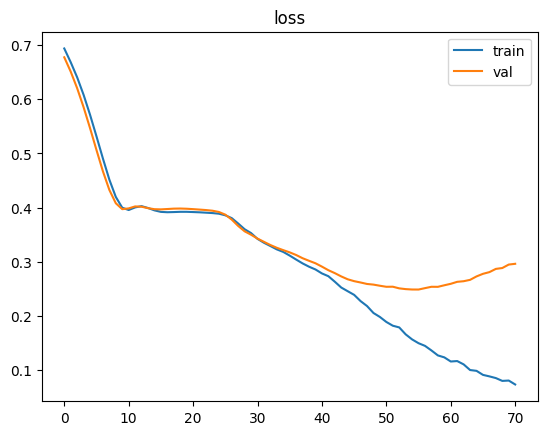

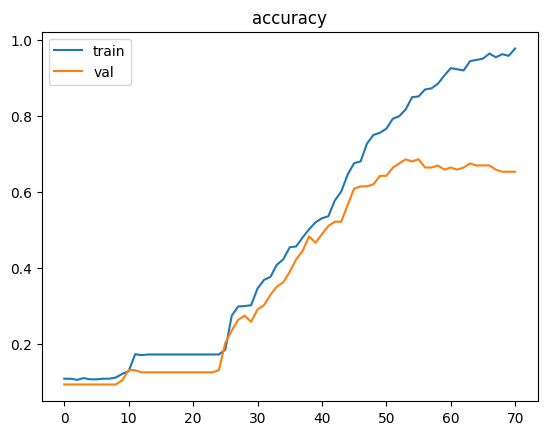

In [67]:
history = model.fit(train, n_epochs=150, batch_size=200, val_batch_size=60)
plot_metrics(history)

In [68]:
train_result = model.evaluate(train)
result = model.evaluate(test)

for measure, value in train_result.items():
    print(f'train_{measure}: {value}')

for measure, value in result.items():
    print(f'{measure}: {value}')

train_loss: 0.1793171993710778
train_accuracy: 0.8040209900249135
loss: 0.30450330810113385
accuracy: 0.5746753324161876


In [132]:
x = torch.rand((1, 64, 600))

## Transformer from https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial6/Transformers_and_MHAttention.html

In [70]:
import math, torch.nn.functional as F

In [82]:
def scaled_dot_product(q, k, v, mask=None):
    d_k = q.size()[-1]
    attn_logits = torch.matmul(q, k.transpose(-2, -1))
    attn_logits = attn_logits / math.sqrt(d_k)
    if mask is not None:
        attn_logits = attn_logits.masked_fill(mask == 0, -9e15)
    attention = F.softmax(attn_logits, dim=-1)
    values = torch.matmul(attention, v)
    return values, attention


# Helper function to support different mask shapes.
# Output shape supports (batch_size, number of heads, seq length, seq length)
# If 2D: broadcasted over batch size and number of heads
# If 3D: broadcasted over number of heads
# If 4D: leave as is
def expand_mask(mask):
    assert mask.ndim > 2, "Mask must be at least 2-dimensional with seq_length x seq_length"
    if mask.ndim == 3:
        mask = mask.unsqueeze(1)
    while mask.ndim < 4:
        mask = mask.unsqueeze(0)
    return mask



class MultiheadAttention(nn.Module):

    def __init__(self, input_dim, embed_dim, num_heads):
        super().__init__()
        assert embed_dim % num_heads == 0, "Embedding dimension must be 0 modulo number of heads."

        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads

        # Stack all weight matrices 1...h together for efficiency
        # Note that in many implementations you see "bias=False" which is optional
        self.qkv_proj = nn.Linear(input_dim, 3*embed_dim)
        self.o_proj = nn.Linear(embed_dim, embed_dim)

        self._reset_parameters()

    def _reset_parameters(self):
        # Original Transformer initialization, see PyTorch documentation
        nn.init.xavier_uniform_(self.qkv_proj.weight)
        self.qkv_proj.bias.data.fill_(0)
        nn.init.xavier_uniform_(self.o_proj.weight)
        self.o_proj.bias.data.fill_(0)

    def forward(self, x, mask=None, return_attention=False):
        batch_size, seq_length, _ = x.size()
        if mask is not None:
            mask = expand_mask(mask)
        qkv = self.qkv_proj(x)

        # Separate Q, K, V from linear output
        qkv = qkv.reshape(batch_size, seq_length, self.num_heads, 3*self.head_dim)
        qkv = qkv.permute(0, 2, 1, 3) # [Batch, Head, SeqLen, Dims]
        q, k, v = qkv.chunk(3, dim=-1)

        # Determine value outputs
        values, attention = scaled_dot_product(q, k, v, mask=mask)
        values = values.permute(0, 2, 1, 3) # [Batch, SeqLen, Head, Dims]
        values = values.reshape(batch_size, seq_length, self.embed_dim)
        o = self.o_proj(values)

        if return_attention:
            return o, attention
        else:
            return o



class EncoderBlock(nn.Module):

    def __init__(self, input_dim, num_heads, dim_feedforward, dropout=0.0):
        """
        Inputs:
            input_dim - Dimensionality of the input
            num_heads - Number of heads to use in the attention block
            dim_feedforward - Dimensionality of the hidden layer in the MLP
            dropout - Dropout probability to use in the dropout layers
        """
        super().__init__()

        # Attention layer
        self.self_attn = MultiheadAttention(input_dim, input_dim, num_heads)

        # Two-layer MLP
        self.linear_net = nn.Sequential(
            nn.Linear(input_dim, dim_feedforward),
            nn.Dropout(dropout),
            # nn.ReLU(inplace=True),
            nn.Linear(dim_feedforward, input_dim)
        )

        # Layers to apply in between the main layers
        self.norm1 = nn.LayerNorm(input_dim)
        self.norm2 = nn.LayerNorm(input_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        # Attention part
        attn_out = self.self_attn(x, mask=mask)
        x = x + self.dropout(attn_out)
        x = self.norm1(x)

        # MLP part
        linear_out = self.linear_net(x)
        x = x + self.dropout(linear_out)
        x = self.norm2(x)

        return x

class TransformerEncoder(nn.Module):

    def __init__(self, num_layers, **block_args):
        super().__init__()
        self.layers = nn.ModuleList([EncoderBlock(**block_args) for _ in range(num_layers)])

    def forward(self, x, mask=None):
        for l in self.layers:
            x = l(x, mask=mask)
        return x

    def get_attention_maps(self, x, mask=None):
        attention_maps = []
        for l in self.layers:
            _, attn_map = l.self_attn(x, mask=mask, return_attention=True)
            attention_maps.append(attn_map)
            x = l(x)
        return attention_maps

In [83]:
import math
import torch.nn.functional as F

In [84]:
x.shape

torch.Size([1, 64, 600])

In [85]:
t = TransformerEncoder(5, input_dim=64, num_heads=8, dim_feedforward=64)
t(torch.rand((10, 600, 64))).shape

torch.Size([10, 600, 64])

In [86]:
class LFCNNtr(BaseModel):

    def __init__(
        self,
        n_channels: int,
        n_times: int,
        n_latent: int,
        filter_size: int,
        pool_factor: int,
        n_outputs: int,
        n_heads = 8
    ):
        super().__init__()
        self.pool_factor = pool_factor
        self.n_latent = n_latent
        self.unmixing_layer = nn.Conv1d(n_channels, n_latent, kernel_size=1, bias=True)
        self.temp_conv = nn.Conv1d(n_latent, n_latent, kernel_size=filter_size, bias=True, groups=n_latent, padding='same')
        self.temp_sel = MultiHeadAttention(n_latent, n_heads, .4)
        self.temp_sel = TransformerEncoder(8, input_dim=8, num_heads=8, dim_feedforward=64)
        final_out_features = (n_times//pool_factor)*n_latent if not n_times%pool_factor else (n_times//pool_factor + 1)*n_latent
        self.fc_layer = nn.Linear(final_out_features, n_outputs)


    def forward(self, x: torch.Tensor):
        x = self.unmixing_layer(x)
        x = self.temp_conv(x)
        x = x[:, :, ::self.pool_factor].contiguous()
        x = torch.permute(x, (0, 2, 1))
        x = self.temp_sel(x)
        x = torch.permute(x, (0, 2, 1))
        x = torch.flatten(x, 1)
        return self.fc_layer(x)

X = torch.rand((1, 64, 600))

LFCNNtr(64, 600, 8, 50, 10, 8)(X)

tensor([[-0.4297, -0.6217, -0.3365, -0.2501, -0.0493, -0.1098, -0.3938, -0.1091]],
       grad_fn=<AddmmBackward0>)

In [87]:
from deepmeg.models.interpretable import LFCNN
# model = TSNet(**lfcnn_kwargs)

model = LFCNNtr(
    **kwargs
)

optimizer = torch.optim.Adam
loss = torch.nn.BCEWithLogitsLoss()
# metric = torchmetrics.functional.classification.binary_accuracy
metric = accuracy

model.compile(
    optimizer,
    loss,
    metric,
    callbacks=[
        PrintingCallback(), # print ongoing training history
        EarlyStopping(patience=15, monitor='loss_val', restore_best_weights=True), # perform early stopping with restoring best weights
        L2Reg(
            [
                # 'unmixing_layer.weight',
                'temp_conv.weight',
            ], lambdas=.01
        ) # l2 regularization for weights of spatial- and temporal filtering layers
    ]
)

In [88]:
model.state_dict().keys()

odict_keys(['unmixing_layer.weight', 'unmixing_layer.bias', 'temp_conv.weight', 'temp_conv.bias', 'temp_sel.layers.0.self_attn.qkv_proj.weight', 'temp_sel.layers.0.self_attn.qkv_proj.bias', 'temp_sel.layers.0.self_attn.o_proj.weight', 'temp_sel.layers.0.self_attn.o_proj.bias', 'temp_sel.layers.0.linear_net.0.weight', 'temp_sel.layers.0.linear_net.0.bias', 'temp_sel.layers.0.linear_net.2.weight', 'temp_sel.layers.0.linear_net.2.bias', 'temp_sel.layers.0.norm1.weight', 'temp_sel.layers.0.norm1.bias', 'temp_sel.layers.0.norm2.weight', 'temp_sel.layers.0.norm2.bias', 'temp_sel.layers.1.self_attn.qkv_proj.weight', 'temp_sel.layers.1.self_attn.qkv_proj.bias', 'temp_sel.layers.1.self_attn.o_proj.weight', 'temp_sel.layers.1.self_attn.o_proj.bias', 'temp_sel.layers.1.linear_net.0.weight', 'temp_sel.layers.1.linear_net.0.bias', 'temp_sel.layers.1.linear_net.2.weight', 'temp_sel.layers.1.linear_net.2.bias', 'temp_sel.layers.1.norm1.weight', 'temp_sel.layers.1.norm1.bias', 'temp_sel.layers.1.norm2

In [89]:
if hasattr(sys.stdout, 'file'):
    sys.stdout = sys.stdout.file

Epoch 0:  loss_train:  0.6932   |    accuracy_train:  0.1201   |    loss_val:  0.5723   |    accuracy_val:  0.1753
Epoch 1:  loss_train:  0.5285   |    accuracy_train:  0.1253   |    loss_val:  0.4458   |    accuracy_val:  0.1808
Epoch 2:  loss_train:  0.4284   |    accuracy_train:  0.1269   |    loss_val:  0.4016   |    accuracy_val:  0.1808
Epoch 3:  loss_train:  0.3984   |    accuracy_train:  0.1303   |    loss_val:  0.3942   |    accuracy_val:  0.1864
Epoch 4:  loss_train:  0.3941   |    accuracy_train:  0.1463   |    loss_val:  0.3954   |    accuracy_val:  0.2045
Epoch 5:  loss_train:  0.3953   |    accuracy_train:  0.1554   |    loss_val:  0.3966   |    accuracy_val:  0.1875
Epoch 6:  loss_train:  0.3958   |    accuracy_train:  0.1471   |    loss_val:  0.3971   |    accuracy_val:  0.1875
Epoch 7:  loss_train:  0.3959   |    accuracy_train:  0.1502   |    loss_val:  0.3980   |    accuracy_val:  0.1875
Epoch 8:  loss_train:  0.3956   |    accuracy_train:  0.1550   |    loss_val:  0

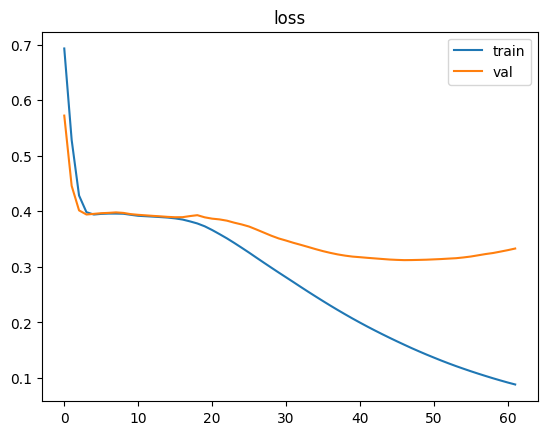

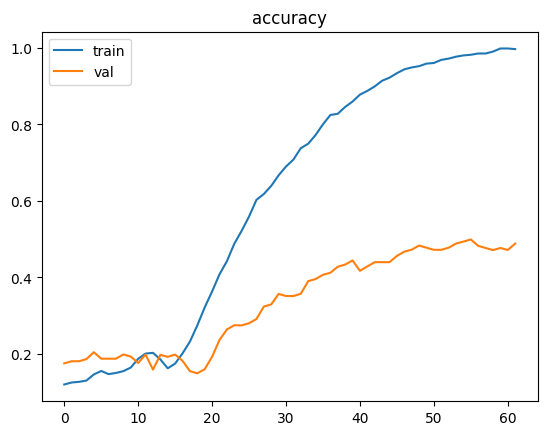

In [90]:
history = model.fit(train, n_epochs=150, batch_size=200, val_batch_size=60)
plot_metrics(history)

In [91]:
train_result = model.evaluate(train)
result = model.evaluate(test)

for measure, value in train_result.items():
    print(f'train_{measure}: {value}')

for measure, value in result.items():
    print(f'{measure}: {value}')

train_loss: 0.1929406537251039
train_accuracy: 0.8375874215906317
loss: 0.3077931593764912
accuracy: 0.4448051967404105
